<a href="https://colab.research.google.com/github/Anshu00027/SAE-for-PINNs/blob/main/SAE-for-Taylor-Green-Vortex-PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import display

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# We are loading the data collected from a trained PINNs model with architecture [3, 25, 25, 3], solving Taylor Vortex Green problem, considering the activations of the last hidden layer (the second hidden layer) which contains 25 neurons
# These activations are collected for all training points(3475). so the shape should be (3475,25)
activations_array = np.load("/content/drive/MyDrive/SAE_project/last_hidden_activations.npy")
print(activations_array.shape)

# Min-Max normalization
min_vals = activations_array.min(axis=0)
max_vals = activations_array.max(axis=0)

activations_normalized = (activations_array - min_vals) / (max_vals - min_vals)

print("Normalized range:", activations_normalized.min(), activations_normalized.max())

(3475, 25)
Normalized range: 0.0 1.0


In [9]:
hidden_tensor = torch.tensor(activations_normalized, dtype=torch.float32)

print(hidden_tensor.shape)

torch.Size([3475, 25])


We use the above activation data as inputs to train a Sparse Autoencoder. The hidden_tensor contains these activations, and we organize them into a dataset where each input equals its target output. To improve training efficiency, we divide the data into mini-batches of 139 samples, allowing the model to iteratively update weights over multiple batches per epoch.

The SparseAutoencoder class defines an encoder-decoder architecture with a hidden layer of size h_dims. A sigmoid activation maps the input to the latent space, while a Tanh activation reconstructs the input from the latent representation. The sparsity constraint is controlled by sparsity_lambda and sparsity_target, which encourage most neurons to remain inactive for a given input, promoting a compact and informative latent representation.

The loss function combines the mean squared error between the output and its reconstruction, which ensures that the autoencoder accurately reconstructs the original activations, with a KL-divergence-based sparsity penalty.
The KL-divergence-based sparsity penalty is applied to the encoded activations to encourage most hidden neurons to remain inactive for each input. It measures the difference between the desired average activation (sparsity_target) and the actual average activation of each hidden neuron

Xavier initialization is used to initialize the weights, ensuring a stable start for training.

In [10]:

# Dataset (input,output)
dataset = TensorDataset(hidden_tensor, hidden_tensor)
dataloader = DataLoader(dataset, batch_size=139, shuffle=True)
# Here, we use mini-batching to improve training efficiency. Instead of processing all 3,475 activation samples at once in a single epoch, the data is divided into smaller batches of 139 samples each. The model iteratively trains on these mini-batches, completing one full pass (epoch) after all batches are processed.


# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda, sparsity_target,xavier_norm_init=True):
        super().__init__()

        # The sparsity_target defines the desired average activation level of the hidden neurons encouraging most neurons to remain inactive for a given input.
        # The sparsity_lambda determines how strongly this sparsity penalty influences the total loss during training.

        self.xavier_norm_init = xavier_norm_init
       # The encoder consists of a fully connected layer that maps the input features to a hidden space (h_dims),by a Sigmoid activation function.
        self.encoder = nn.Sequential(
            nn.Linear(in_dims, h_dims),
            nn.Sigmoid() )

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)
            nn.init.constant_(self.encoder[0].bias, 0)

        # The decoder reconstructs the original input from the compressed hidden representation.
        self.decoder = nn.Sequential(
            nn.Linear(h_dims, in_dims),
            nn.Tanh())

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)
            nn.init.constant_(self.decoder[0].bias, 0)

        self.sparsity_lambda = sparsity_lambda
        self.sparsity_target = sparsity_target

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    # This function computes the KL sparsity penalty, which encourages the hidden layer activations to remain close to a target sparsity level. This sparsity penalty is applied on the encoded activations
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = 1e-8
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1-epsilon)
        kl_div = rho * torch.log(rho / rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat))
        return self.sparsity_lambda * torch.sum(kl_div)

    def loss_function(self, decoded, x, encoded):
        mse_loss = nn.functional.mse_loss(decoded, x)
        return mse_loss + self.sparsity_penalty(encoded)




>>> Training SAE | h_dim=50, sparsity_target=0.01
 Done: h_dim=50, sparsity_target=0.01, Final Loss=0.000031


>>> Training SAE | h_dim=50, sparsity_target=0.04
 Done: h_dim=50, sparsity_target=0.04, Final Loss=0.000019


>>> Training SAE | h_dim=50, sparsity_target=0.08
 Done: h_dim=50, sparsity_target=0.08, Final Loss=0.000020


>>> Training SAE | h_dim=50, sparsity_target=0.12
 Done: h_dim=50, sparsity_target=0.12, Final Loss=0.000022


>>> Training SAE | h_dim=50, sparsity_target=0.16
 Done: h_dim=50, sparsity_target=0.16, Final Loss=0.000028


>>> Training SAE | h_dim=50, sparsity_target=0.2
 Done: h_dim=50, sparsity_target=0.2, Final Loss=0.000031


>>> Training SAE | h_dim=70, sparsity_target=0.01
 Done: h_dim=70, sparsity_target=0.01, Final Loss=0.000021


>>> Training SAE | h_dim=70, sparsity_target=0.04
 Done: h_dim=70, sparsity_target=0.04, Final Loss=0.000014


>>> Training SAE | h_dim=70, sparsity_target=0.08
 Done: h_dim=70, sparsity_target=0.08, Final Loss=0.000017


>>

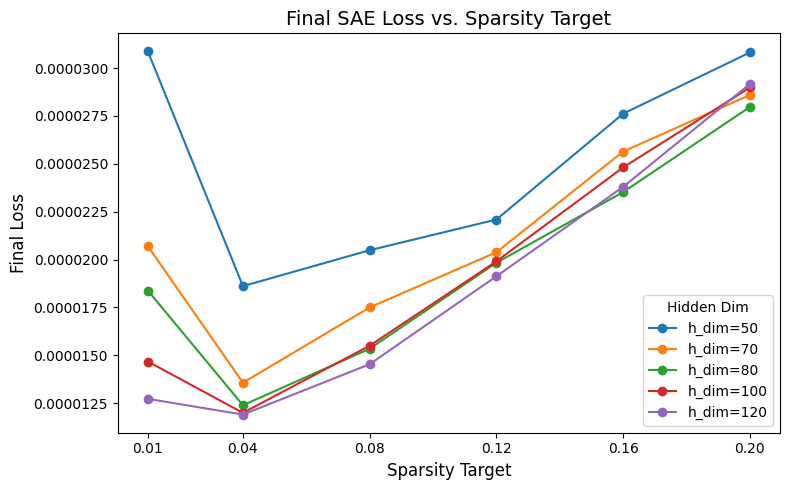

In [81]:
# Training SAE for differnet latent dimensions

def train_sae(hidden_tensor, dataloader, h_dim, sparsity_target,
              sparsity_lambda, lr, n_epochs, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_dim = hidden_tensor.shape[1]
    sae = SparseAutoencoder(in_dim, h_dim, sparsity_lambda, sparsity_target).to(device)
    optimizer = torch.optim.Adam(sae.parameters(), lr=lr)

    print(f"\n>>> Training SAE | h_dim={h_dim}, sparsity_target={sparsity_target}")
    for epoch in range(n_epochs):
        total_loss = 0
        for batch_x, _ in dataloader:
            batch_x = batch_x.to(device)
            optimizer.zero_grad()
            encoded, decoded = sae(batch_x)
            loss = sae.loss_function(decoded, batch_x, encoded)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    final_loss = total_loss / len(dataloader)
    print(f" Done: h_dim={h_dim}, sparsity_target={sparsity_target}, Final Loss={final_loss:.6f}\n")
    return final_loss

# Experiment configurations

h_dims_list = [50,70,80,100,120]      # hidden layer sizes
sparsity_targets = [0.01,0.04,0.08,0.12,0.16,0.2]   # sparsity targets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run and store results

results = {}  # store final loss per config

for h_dim in h_dims_list:
    losses = []
    for sparsity_target in sparsity_targets:
        final_loss = train_sae(hidden_tensor, dataloader, h_dim, sparsity_target,
                               sparsity_lambda=2e-4, lr=1e-3, n_epochs=1000, device=device)
        losses.append(final_loss)
    results[h_dim] = losses

# Plot results
plt.figure(figsize=(8, 5))
for h_dim, losses in results.items():
    plt.plot(sparsity_targets, losses, marker='o', label=f'h_dim={h_dim}')
plt.xlabel('Sparsity Target', fontsize=12)
plt.ylabel('Final Loss', fontsize=12)
plt.title('Final SAE Loss vs. Sparsity Target', fontsize=14)
plt.legend(title='Hidden Dim')
plt.xticks(sparsity_targets)
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
plt.show()


Taking that latent dimension where the reconstruction loss is the best

In [82]:
# Initialize and train
in_dims = hidden_tensor.shape[1]
h_dims = 120
sparsity_lambda=2e-4
sparsity_target=0.04
sae = SparseAutoencoder(in_dims, h_dims,sparsity_lambda, sparsity_target)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sae.to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)

# Training
n_epochs = 2000

for epoch in range(n_epochs):
    total_loss = 0
    for batch_x, _ in dataloader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        encoded, decoded = sae(batch_x)
        loss = sae.loss_function(decoded, batch_x, encoded)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Keep last batch activations

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {total_loss/len(dataloader):.6f}")



last_batch, _ = next(iter(dataloader))
with torch.no_grad():
    last_batch_encoded, _ = sae(last_batch.to(device))

last_batch_encoded = last_batch_encoded.cpu().numpy()
np.save("last_batch_encoded.npy", last_batch_encoded)
print("Saved last mini-batch encoded activations:", last_batch_encoded.shape)


# Save the encoded representation
with torch.no_grad():
    encoded, _ = sae(hidden_tensor.to(device))

encoded = encoded.cpu().numpy()
np.save("train_last_hidden_encoded.npy", encoded)
print("Saved SAE encoded features shape:", encoded.shape)

Epoch 1/2000 - Loss: 0.169156
Epoch 101/2000 - Loss: 0.002649
Epoch 201/2000 - Loss: 0.000702
Epoch 301/2000 - Loss: 0.000232
Epoch 401/2000 - Loss: 0.000085
Epoch 501/2000 - Loss: 0.000036
Epoch 601/2000 - Loss: 0.000022
Epoch 701/2000 - Loss: 0.000016
Epoch 801/2000 - Loss: 0.000014
Epoch 901/2000 - Loss: 0.000012
Epoch 1001/2000 - Loss: 0.000011
Epoch 1101/2000 - Loss: 0.000010
Epoch 1201/2000 - Loss: 0.000009
Epoch 1301/2000 - Loss: 0.000009
Epoch 1401/2000 - Loss: 0.000008
Epoch 1501/2000 - Loss: 0.000008
Epoch 1601/2000 - Loss: 0.000008
Epoch 1701/2000 - Loss: 0.000008
Epoch 1801/2000 - Loss: 0.000007
Epoch 1901/2000 - Loss: 0.000007
Saved last mini-batch encoded activations: (139, 120)
Saved SAE encoded features shape: (3475, 120)


now we are printing the activation values of neurons for each sample in the mini-batch.
    
Each row corresponds to the activation of neuron for a single sample from the mini-batch.

In [96]:
# Convert hidden activations to a DataFrame
activations = np.array(last_batch_encoded)  # (batch_size, num_neurons)
df = pd.DataFrame(activations, columns=[f"Neuron {i+1}" for i in range(activations.shape[1])])
# Show first 10 samples (rows) and first 10 neurons (columns) for readability
df_subset = df.iloc[:10, :10]

df_subset


,Neuron 1,Neuron 2,Neuron 3,Neuron 4,Neuron 5,Neuron 6,Neuron 7,Neuron 8,Neuron 9,Neuron 10
0,0.157145,0.185818,0.128038,0.214724,0.084271,0.167617,0.520904,0.272904,0.217658,0.212093
1,0.199598,0.138045,0.254433,0.171805,0.215561,0.168231,0.084759,0.105309,0.071153,0.163261
2,0.228732,0.040573,0.292740,0.158930,0.213862,0.346633,0.005333,0.138718,0.266486,0.197423
3,0.228699,0.196091,0.135998,0.172930,0.205574,0.079222,0.243536,0.100078,0.061143,0.264050
4,0.154909,0.183088,0.184542,0.189170,0.154018,0.150064,0.239922,0.147589,0.077618,0.155509
5,0.148711,0.176842,0.183886,0.194215,0.139452,0.165325,0.228559,0.163317,0.090600,0.146158
6,0.286358,0.171347,0.148293,0.169883,0.508969,0.105930,0.024470,0.100105,0.139557,0.284248
7,0.299790,0.071387,0.294659,0.121273,0.446775,0.132228,0.027814,0.056720,0.068191,0.306466
8,0.391183,0.382494,0.114943,0.152683,0.523096,0.035822,0.139288,0.066805,0.060324,0.301721
9,0.141075,0.322365,0.134459,0.308108,0.057778,0.370983,0.162141,0.366137,0.565848,0.150082


 As we can see, the tabular representation of activations lists raw numeric values for each neuron (columns) across samples in the mini-batch (rows).
 However, these values alone are not visually intuitive it is difficult to quickly identify which neurons/feature are more active, or how activation intensity varies across samples.
 To gain better insight, we now visualize the same activations in a graphical form using a heatmap-style layout for each neuron seperately, where color intensity indicates the magnitude of neuron activations.


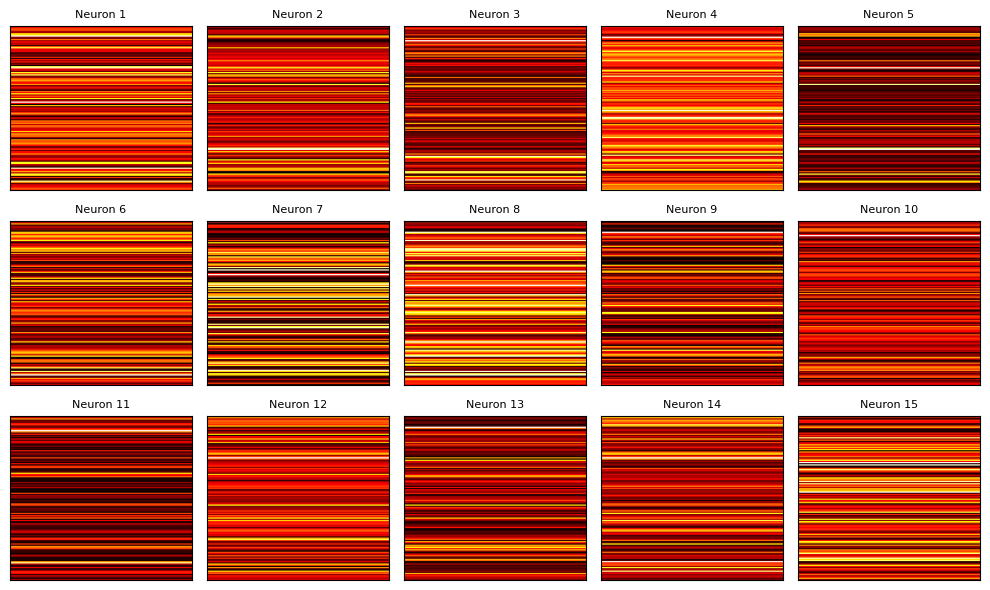

In [97]:
def plot_last_batch_activations(activations, num_neurons, neurons_per_row, save_path=None):
    num_rows = (num_neurons + neurons_per_row - 1) // neurons_per_row
    fig, axes = plt.subplots(num_rows, neurons_per_row, figsize=(neurons_per_row * 2, num_rows * 2))
    axes = axes.flatten()

    """
    Visualizes neuron activations across samples in the last mini-batch.

    Each subplot represents one neuron. The vertical axis shows samples in the batch.
    Color intensity is the  activation magnitude.
    """


    for i in range(num_neurons):
        if i >= activations.shape[1]:
            break
        ax = axes[i]
        # Each neuron activation across the last batch samples

        ax.imshow(activations[:, i].reshape(-1, 1), aspect='auto', cmap='hot')
        ax.set_title(f'Neuron {i+1}', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


# Example call
plot_last_batch_activations(last_batch_encoded, num_neurons=15, neurons_per_row=5, save_path="pic.png")


In [140]:
#  Load encoded activations
encoded_full = np.load("train_last_hidden_encoded.npy")
last_batch_encoded = np.load("last_batch_encoded.npy")

num_samples, num_neurons = encoded_full.shape
print(f"Full encoded shape: {encoded_full.shape}")

# Compute per-neuron threshold from last batch
K = 10
thresholds = np.zeros(num_neurons)
for n in range(num_neurons):
    topk_values = np.sort(last_batch_encoded[:, n])[-K:]
    thresholds[n] = np.mean(topk_values)
print("Computed thresholds for all neurons.")

#  Check activation per neuron for each sample
active_matrix = encoded_full > thresholds

# Count how many samples activate each neuron
neuron_activity_counts = np.sum(active_matrix, axis=0)
# axis zero means For each neuron, count how many samples in which it is activated

#  Display top 10 most frequently active neurons
top_indices = np.argsort(-neuron_activity_counts)[:10]
print("\nTop 10 most active neurons:")
for idx in top_indices:
    print(f"Neuron {idx}: active in {neuron_activity_counts[idx]} / {num_samples} samples")


Full encoded shape: (3475, 100)
Computed thresholds for all neurons.

Top 10 most active neurons:
Neuron 93: active in 262 / 3475 samples
Neuron 77: active in 210 / 3475 samples
Neuron 45: active in 192 / 3475 samples
Neuron 33: active in 187 / 3475 samples
Neuron 76: active in 181 / 3475 samples
Neuron 32: active in 171 / 3475 samples
Neuron 84: active in 149 / 3475 samples
Neuron 89: active in 146 / 3475 samples
Neuron 48: active in 143 / 3475 samples
Neuron 75: active in 135 / 3475 samples


Now we want to check which sample input activates most of feature/neurosn

In [137]:
sample_activity_counts = np.sum(active_matrix, axis=1)
# axix 1 means count how many neurons are active for a sample

# Find the sample(s) that activated the most neurons
most_active_sample_idx = np.argmax(sample_activity_counts)
most_active_count = sample_activity_counts[most_active_sample_idx]

print(f"\nSample {most_active_sample_idx} activated {most_active_count} / {num_neurons} neurons (most active).")

# Display top 10 most activating samples
top_samples = np.argsort(-sample_activity_counts)[:10]
print("\nTop 10 most neuron-activating samples:")
for idx in top_samples:
    print(f"Sample {idx}: activated {sample_activity_counts[idx]} neurons")



Sample 3400 activated 33 / 100 neurons (most active).

Top 10 most neuron-activating samples:
Sample 3445: activated 33 neurons
Sample 3400: activated 33 neurons
Sample 3440: activated 31 neurons
Sample 3150: activated 30 neurons
Sample 2925: activated 29 neurons
Sample 3429: activated 27 neurons
Sample 3379: activated 27 neurons
Sample 2700: activated 26 neurons
Sample 2475: activated 25 neurons
Sample 3428: activated 24 neurons
